# JAX-CFD demo

This initial demonstration shows how to use JAX-CFD to simulate decaying turbulence in 2D.

In [34]:
from colabtools import adhoc_import

with adhoc_import.Google3CitcClient('whirl_collocated', 'pnorgaard'):
  import jax
  import jax.numpy as jnp
  import jax_cfd.base as base
  import jax_cfd.collocated as collocated
  import jax_cfd.data.xarray_utils as xru
  import numpy as np
  import seaborn
  import xarray

funcutils = base.funcutils

In [ ]:
size = 256
density = 1.
viscosity = 1e-3
seed = 0
inner_steps = 25
outer_steps = 100

max_velocity = 2.0
cfl_safety_factor = 0.5


# Define the physical dimensions of the simulation.
grid = base.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Choose a time step.
dt = base.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0_collocated = collocated.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)

# Define a step function and use it to compute a trajectory.
# For linear convection, add the argument to semi_implicit_navier_stokes:
#   `convect=collocated.advection.convect_linear`
step_fn_collocated = funcutils.repeated(
    collocated.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(funcutils.trajectory(step_fn_collocated, outer_steps))
%time _, trajectory_collocated = jax.device_get(rollout_fn(v0_collocated))

CPU times: user 2.52 s, sys: 181 ms, total: 2.7 s
Wall time: 18.8 s


In [ ]:
# load into xarray for visualization and analysis
ds_collocated = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory_collocated[0].data),
        'v': (('time', 'x', 'y'), trajectory_collocated[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)

In [ ]:
ds_collocated

<xarray.Dataset>
Dimensions:  (time: 100, x: 256, y: 256)
Coordinates:
  * x        (x) float32 0.01227 0.03682 0.06136 0.0859 ... 6.222 6.246 6.271
  * y        (y) float32 0.01227 0.03682 0.06136 0.0859 ... 6.222 6.246 6.271
  * time     (time) float64 0.0 0.1534 0.3068 0.4602 ... 14.73 14.88 15.03 15.19
Data variables:
    u        (time, x, y) float32 -0.8814 -0.9193 -0.9538 ... 0.447 0.4523
    v        (time, x, y) float32 0.1672 0.1598 0.1533 ... 0.1174 0.1116 0.1052

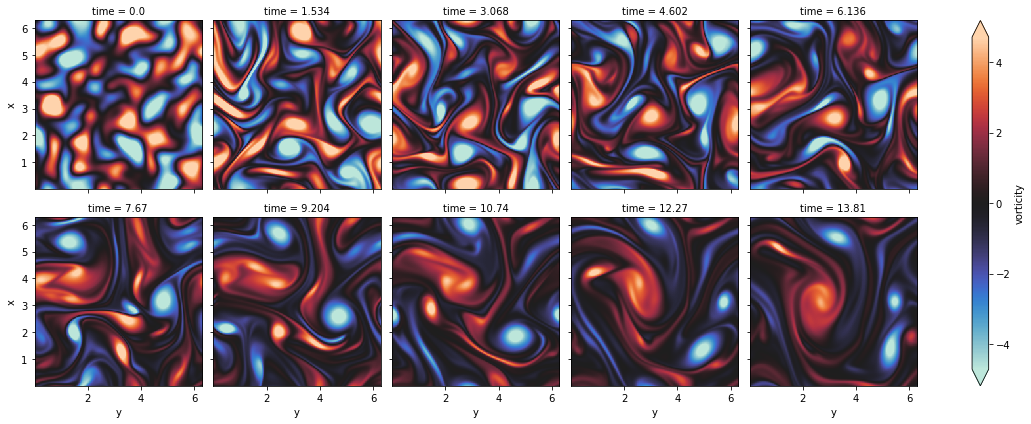

In [ ]:
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds_collocated.pipe(vorticity).thin(time=10)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));

Compare this to the staggered grid result

In [ ]:
# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0_staggered = base.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)

# Define a step function and use it to compute a trajectory.
step_fn_staggered = funcutils.repeated(
    base.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(funcutils.trajectory(step_fn_staggered, outer_steps))
%time _, trajectory_staggered = jax.device_get(rollout_fn(v0_staggered))

CPU times: user 1.5 s, sys: 50.7 ms, total: 1.55 s
Wall time: 1.29 s


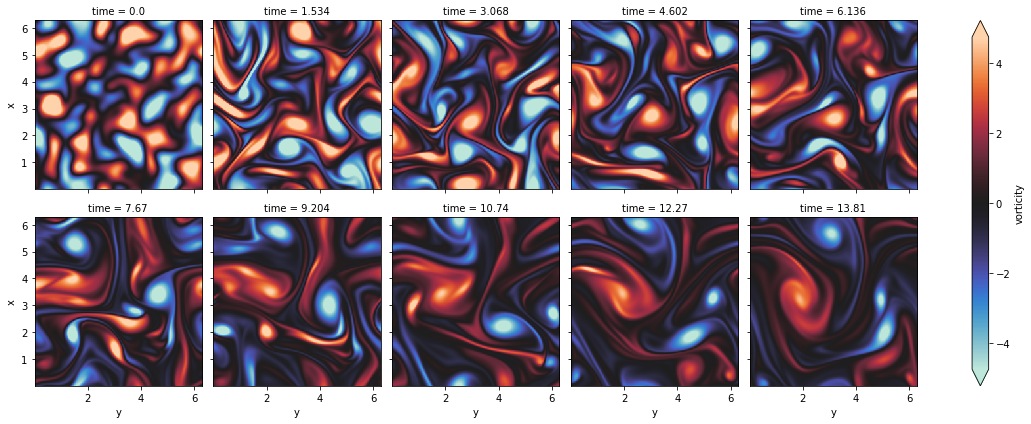

In [ ]:
# load into xarray for visualization and analysis
ds_staggered = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory_staggered[0].data),
        'v': (('time', 'x', 'y'), trajectory_staggered[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)

def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds_staggered.pipe(vorticity).thin(time=10)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));

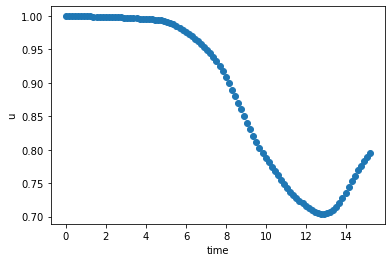

In [48]:
def correlation(x, y):
  state_dims = ['x', 'y']
  p  = xru.normalize(x, state_dims) * xru.normalize(y, state_dims)
  return p.sum(state_dims)

correlation(ds_collocated, ds_staggered).plot.scatter('time', 'u')

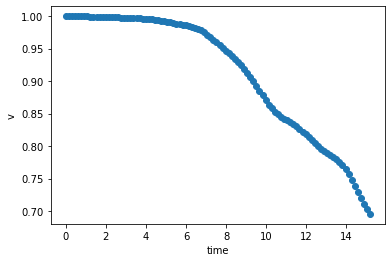

In [49]:
correlation(ds_collocated, ds_staggered).plot.scatter('time', 'v')